### Experiments setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
from pycox import datasets
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime

np.random.seed(1234)
_ = torch.manual_seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = datasets.metabric.read_df()
feat_cols = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
feats = df[feat_cols]
surv_label = df[["duration", "event"]].values

0:	[0s / 0s],		train_loss: 0.7041,	val_loss: 0.6607
1:	[0s / 0s],		train_loss: 0.6628,	val_loss: 0.6464
2:	[0s / 0s],		train_loss: 0.6455,	val_loss: 0.6061
3:	[0s / 0s],		train_loss: 0.6494,	val_loss: 0.6085
4:	[0s / 0s],		train_loss: 0.6455,	val_loss: 0.6048
5:	[0s / 0s],		train_loss: 0.6292,	val_loss: 0.5867
6:	[0s / 0s],		train_loss: 0.6203,	val_loss: 0.5963
7:	[0s / 0s],		train_loss: 0.6163,	val_loss: 0.5884
8:	[0s / 0s],		train_loss: 0.6150,	val_loss: 0.5948
9:	[0s / 0s],		train_loss: 0.6233,	val_loss: 0.5924
10:	[0s / 0s],		train_loss: 0.6279,	val_loss: 0.5979
11:	[0s / 0s],		train_loss: 0.6113,	val_loss: 0.5858
12:	[0s / 0s],		train_loss: 0.6112,	val_loss: 0.5860
13:	[0s / 0s],		train_loss: 0.6306,	val_loss: 0.5840
14:	[0s / 0s],		train_loss: 0.6064,	val_loss: 0.5732
15:	[0s / 0s],		train_loss: 0.6086,	val_loss: 0.5790
16:	[0s / 1s],		train_loss: 0.6166,	val_loss: 0.5822
17:	[0s / 1s],		train_loss: 0.6004,	val_loss: 0.5820
18:	[0s / 1s],		train_loss: 0.5997,	val_loss: 0.5733
19:

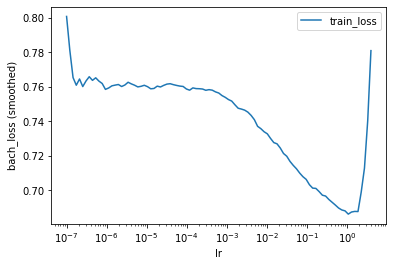

In [3]:
# Split data
df_val = df.sample(frac=0.2)
df_train = df.drop(df_val.index)

x_train = df_train[feat_cols].values
x_val = df_val[feat_cols].values

y_train = (df_train['duration'].values, df_train['event'].values)
y_val = (df_val['duration'].values, df_val['event'].values)
val = tt.tuplefy(x_val, y_val)

# Train the model
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

estimator = CoxTime(net, tt.optim.Adam)

batch_size = 256
lrfinder = estimator.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

estimator.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = estimator.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

_ = estimator.compute_baseline_hazards()

In [4]:
# Load model explainer
from src.explainer import explainer
model_explainer = explainer(estimator, feats, surv_label)

### Prediction

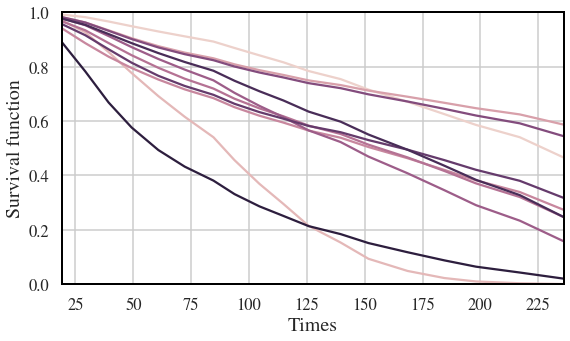

In [5]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data)
prediction.plot_prediction(surv_pred, "survival")

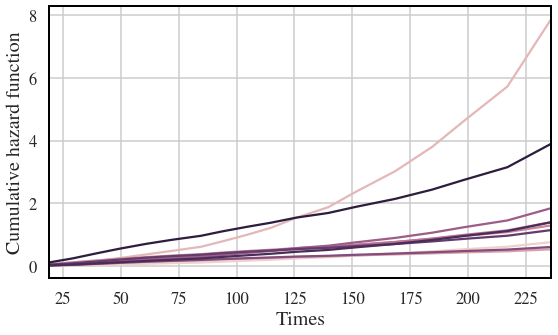

In [6]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

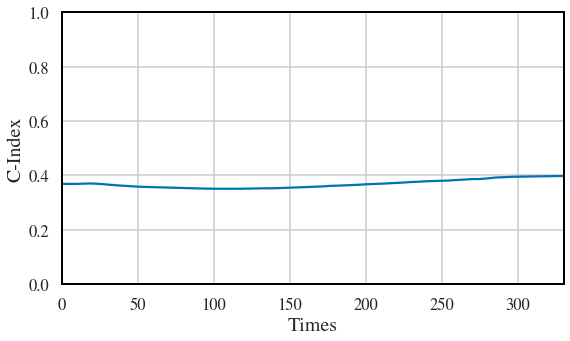

In [7]:
from src import performance
eval_times = np.unique(surv_label[:, 0])[::10]

# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index")

In [8]:
print(cindex_perf.head(20))

        times      perf
0    0.000000  0.368959
1    2.500000  0.368832
2    5.500000  0.368690
3    9.600000  0.368872
4   11.700000  0.369279
5   14.166667  0.369616
6   15.366667  0.370101
7   16.600000  0.370314
8   18.233334  0.370377
9   19.566668  0.370280
10  20.666666  0.370063
11  21.933332  0.369850
12  23.366667  0.369429
13  24.333334  0.369091
14  25.466667  0.368640
15  27.200001  0.367936
16  28.566668  0.367168
17  29.666666  0.366572
18  30.866667  0.365973
19  31.799999  0.365570


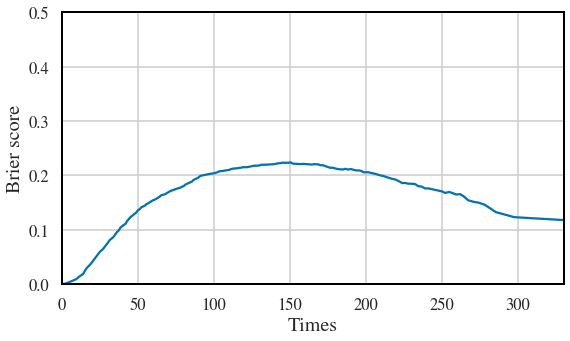

In [9]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score")

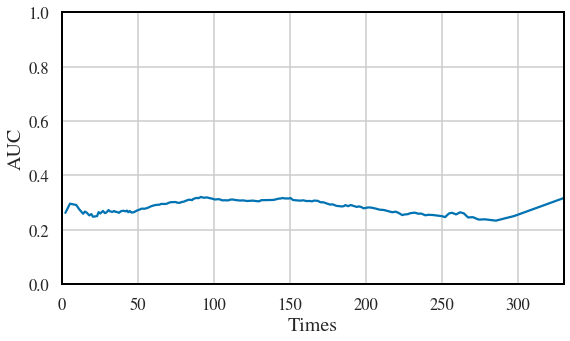

In [10]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc")

### Local explaination

In [7]:
from src import local_explaination

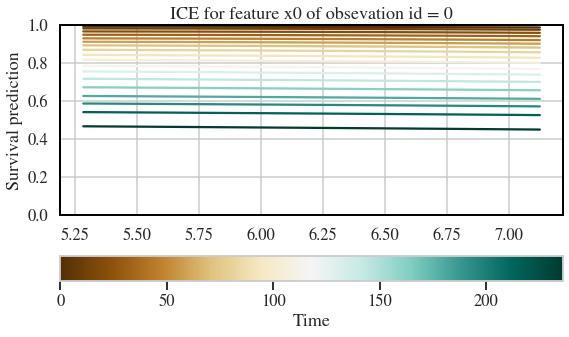

In [8]:
# individual conditional expectation
explained_feature = "x0"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(ICE_df, explained_feature)

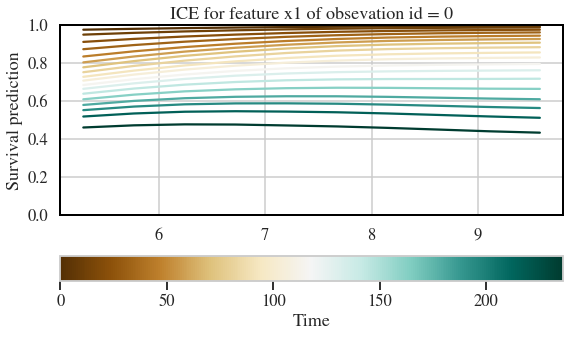

In [9]:
# individual conditional expectation
explained_feature = "x1"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(ICE_df, explained_feature)

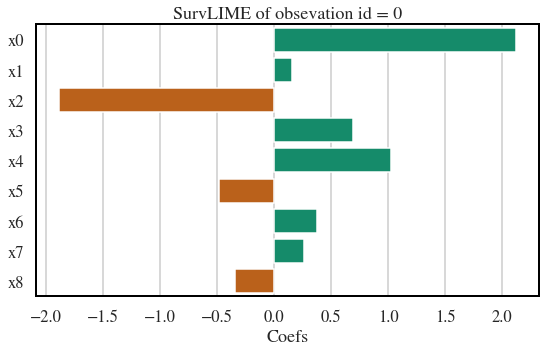

In [11]:
# SurvLIME
SurvLIME_df = local_explaination.SurvLIME(model_explainer, explained_data, surv_label, 100)
local_explaination.plot_SurvLIME(SurvLIME_df)

### Global explaination

In [15]:
from src import global_explaination

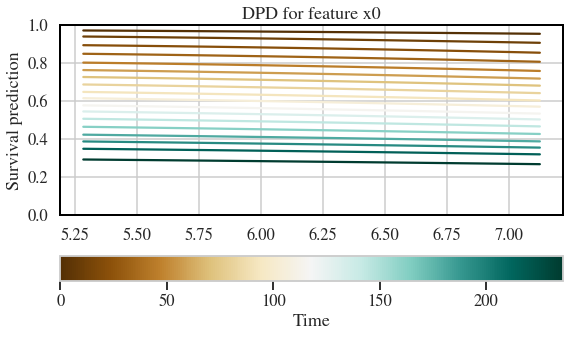

In [16]:
# partial dependence plot
explained_feature = "x0"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature, n_sel_samples=10)
global_explaination.plot_PDP(PDP_df)

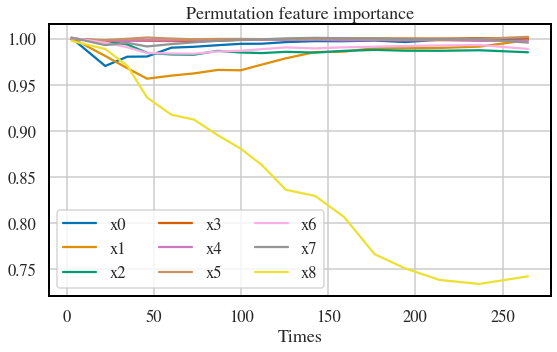

In [19]:
# permuatation feature importance
eval_times = np.unique(surv_label[:, 0])[10::100]
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, feats, 
                                                                        surv_label, eval_times=eval_times, 
                                                                        n_perm=3)
global_explaination.plot_PFI(feat_importance_df)